In [7]:
import pandas as pd
import numpy as np
from datetime import datetime

pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_parquet('../data/processed_encoded/full_valid.parquet.gzip')

In [6]:
df.head()

,max_temperature_normal_f,SNOW_PRI,daily_preciptation_normal_inches,SEGMENT_TY,store_and_fwd_flag,passenger_count,TRAFDIR,day_of_week,hour_of_day,vendor_id,pickup_datetime,RW_TYPE,BIKE_TRAFD,pickup_cluster,POST_TYPE,dropoff_cluster,min_temperature_normal_f,BIKE_LANE,period_of_day,PRE_DIRECT,BOROCODE,avg_temperature_normal_f,ST_WIDTH,PRE_TYPE
0,40,0,0.12,1,0,1,0,1,10,1,2016-01-05 10:07:14,2,2,0,1,0,29,1,1,0,0,35,44.0,1
1,40,0,0.12,0,0,1,0,3,14,2,2016-01-07 14:38:51,0,0,0,0,3,29,0,0,0,0,34,60.0,0
2,75,0,0.14,1,0,2,0,6,22,1,2016-05-29 22:11:39,2,2,0,1,0,59,1,2,0,0,67,54.0,1
3,45,0,0.13,1,0,5,0,1,12,2,2016-03-01 12:33:26,2,2,0,4,3,32,1,0,0,0,39,32.0,1
4,61,0,0.13,0,0,1,0,3,18,2,2016-04-14 18:52:23,2,2,1,7,0,45,1,2,0,1,53,36.0,1


# Aggregate by day

In [12]:
def p99(x):
    return x.quantile(0.99)

def p75(x):
    return x.quantile(0.75)

In [63]:
# Start with basic ones to create a baseline
df['year_month_day'] = df['pickup_datetime'].apply(lambda x:datetime.strftime(x, '%Y%m%d')).astype(int)

In [74]:
df_agg = df.groupby('year_month_day').agg({
        'vendor_id' : 'count',
        'max_temperature_normal_f' : 'max',
        'min_temperature_normal_f' : 'max',
        'daily_preciptation_normal_inches' : 'max',
        'passenger_count' : 'sum',
        'day_of_week' : 'max',
        'period_of_day' : ['mean', p75, p99],
        'hour_of_day' : ['mean', p75, p99]
    }).reset_index()

In [75]:
features_rename = [
    'year_month_day',
    'qty_travels_today',
    'max_temperature_normal_f',
    'min_temperature_normal_f',
    'daily_preciptation_normal_inches',
    'passenger_count',
    'day_of_week',
    'period_of_day_mean',
    'period_of_day_p75',
    'period_of_day_p99',
    'hour_of_day_mean',
    'hour_of_day_p75',
    'hour_of_day_p99'
]

In [76]:
df_agg.columns = features_rename

<Axes: >

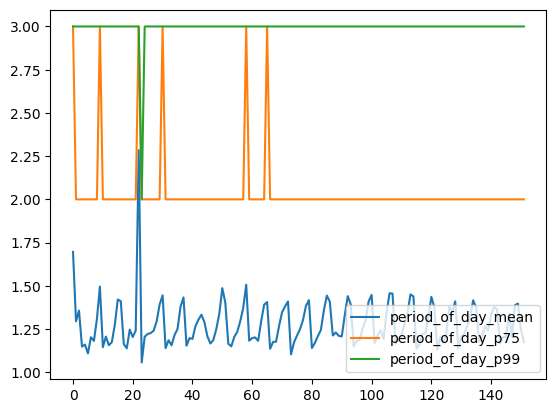

In [77]:
# Need to encode properly, maybe create as integer
df_agg.sort_values(by='year_month_day')[['period_of_day_mean', 
                                         'period_of_day_p75', 
                                         'period_of_day_p99']].plot()

<Axes: >

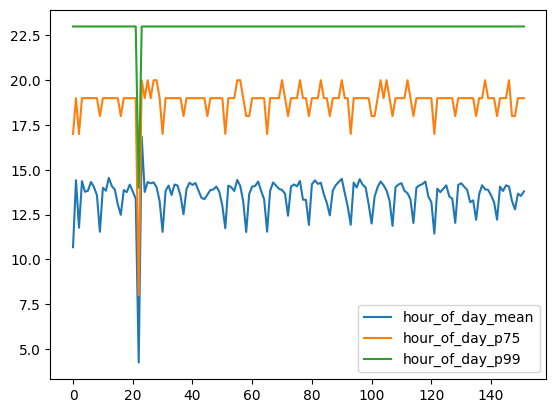

In [78]:
df_agg.sort_values(by='year_month_day')[['hour_of_day_mean', 
                                         'hour_of_day_p75', 
                                         'hour_of_day_p99']].plot()

# Fix Target

In [79]:
df_agg['qty_travels'] = df_agg.qty_travels_today.shift(-1)

In [80]:
df_agg = df_agg.iloc[:-1].reset_index(drop=True)

<Axes: >

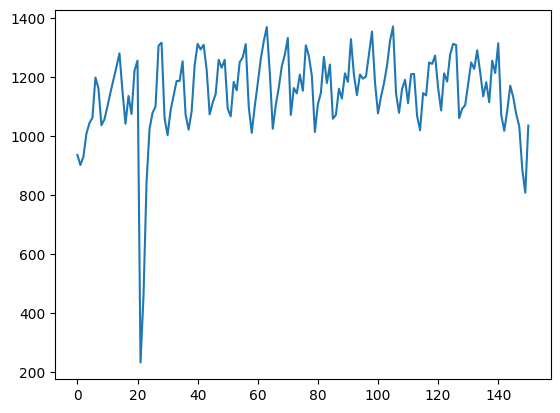

In [82]:
df_agg.qty_travels.plot()

In [81]:
df_agg.head()

,year_month_day,qty_travels_today,max_temperature_normal_f,min_temperature_normal_f,daily_preciptation_normal_inches,passenger_count,day_of_week,period_of_day_mean,period_of_day_p75,period_of_day_p99,hour_of_day_mean,hour_of_day_p75,hour_of_day_p99,qty_travels
0,20160101,1045,41,30,0.12,1855,4,1.695694,3.0,3.0,10.680383,17.0,23.0,936.0
1,20160102,936,40,30,0.12,1614,5,1.294872,2.0,3.0,14.418803,19.0,23.0,902.0
2,20160103,902,40,29,0.11,1552,6,1.356984,2.0,3.0,11.768293,17.0,23.0,930.0
3,20160104,930,40,29,0.13,1523,0,1.148387,2.0,3.0,14.366667,19.0,23.0,1008.0
4,20160105,1008,40,29,0.12,1639,1,1.159722,2.0,3.0,13.773810,19.0,23.0,1044.0
